In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, BooleanType, DateType, TimestampType
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from graphframes import GraphFrame
from pyspark import StorageLevel
import matplotlib.pyplot as plt
import numpy as np

Business Question:
1. Predict the status of the airplane (On Time / Delay)

    Decisions to cancel and reserve flights are usually caused by uncontrollable external factors (e.g., weather, airport closures, etc.) that may not be directly inferred from our current features, so they are more difficult to predict and of less business value.

2. Graph Analysis

In [2]:
# Set up Spark session
spark = SparkSession.builder.appName("FlightPredictionAndGraphAnalysis") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.1-spark2.4-s_2.11") \
    .getOrCreate()
conf = spark.sparkContext._conf.setAll([
    ('spark.executor.memory', '16g'),  
    ('spark.executor.cores', '6'),    
    ('spark.cores.max', '32'),        
    ('spark.driver.memory', '16g'),
    ('spark.sql.broadcastTimeout', '7200'),
    ('spark.sql.autoBroadcastJoinThreshold', '-1'),
    ('spark.storage.replication', '2')
])

In [3]:
# Define the schema for the dataset
schema = StructType([
    StructField("FlightDate", DateType(), True),
    StructField("Airline", StringType(), True),
    StructField("Origin", StringType(), True),
    StructField("Dest", StringType(), True),
    StructField("Cancelled", BooleanType(), True),
    StructField("Diverted", BooleanType(), True),
    StructField("CRSDepTime", TimestampType(), True),
    StructField("DepTime", TimestampType(), True),
    StructField("DepDelayMinutes", DoubleType(), True),
    StructField("ArrTime", TimestampType(), True),
    StructField("ArrDelayMinutes", DoubleType(), True),
    StructField("AirTime", DoubleType(), True),
    StructField("CRSElapsedTime", DoubleType(), True),
    StructField("ActualElapsedTime", DoubleType(), True),
    StructField("Distance", DoubleType(), True),
    StructField("Flight_Number_Operating_Airline", IntegerType(), True),
    StructField("TaxiOut", DoubleType(), True),
    StructField("WheelsOff", TimestampType(), True),
    StructField("WheelsOn", TimestampType(), True),
    StructField("TaxiIn", DoubleType(), True),
    StructField("CRSArrTime", TimestampType(), True),
    StructField("Airline_index", DoubleType(), False),
    StructField("Origin_index", DoubleType(), False),
    StructField("Dest_index", DoubleType(), False),
    StructField("Flight_Number_Operating_Airline_index", DoubleType(), False)
])

In [4]:
#bucket_path = "gs://msca-bdp-student-gcs/Group4/encoded_df_missing_"
bucket_path = "gs://msca-bdp-student-gcs/Group4/encoded_df"
df = spark.read.option("header", "true").schema(schema).csv(bucket_path)
df.show(5)

+----------+-------+------+----+---------+--------+-------------------+-------------------+---------------+-------------------+---------------+-------+--------------+-----------------+--------+-------------------------------+-------+-------------------+-------------------+------+-------------------+-------------+------------+----------+-------------------------------------+
|FlightDate|Airline|Origin|Dest|Cancelled|Diverted|         CRSDepTime|            DepTime|DepDelayMinutes|            ArrTime|ArrDelayMinutes|AirTime|CRSElapsedTime|ActualElapsedTime|Distance|Flight_Number_Operating_Airline|TaxiOut|          WheelsOff|           WheelsOn|TaxiIn|         CRSArrTime|Airline_index|Origin_index|Dest_index|Flight_Number_Operating_Airline_index|
+----------+-------+------+----+---------+--------+-------------------+-------------------+---------------+-------------------+---------------+-------+--------------+-----------------+--------+-------------------------------+-------+-------------

In [5]:
# Dropping unnecessary columns
df = df.drop("Cancelled", "Diverted", "CRSDepTime", "DepTime", "DepDelayMinutes", "AirTime", "CRSElapsedTime", "ActualElapsedTime", "TaxiOut", "WheelsOff", "WheelsOn", "TaxiIn", "CRSArrTime")

In [6]:
# Data shape
num_rows = df.count()
num_columns = len(df.columns)
print(num_rows, num_columns)

76969550 12


In [7]:
# View data
df.show(20)
df.printSchema()

+----------+-------+------+----+-------------------+---------------+--------+-------------------------------+-------------+------------+----------+-------------------------------------+
|FlightDate|Airline|Origin|Dest|            ArrTime|ArrDelayMinutes|Distance|Flight_Number_Operating_Airline|Airline_index|Origin_index|Dest_index|Flight_Number_Operating_Airline_index|
+----------+-------+------+----+-------------------+---------------+--------+-------------------------------+-------------+------------+----------+-------------------------------------+
|2018-04-19|     DL|   JFK| MCO|2018-04-19 11:03:00|           -7.0|   944.0|                           2822|          1.0|        18.0|      13.0|                               2602.0|
|2018-04-19|     DL|   MSP| SLC|2018-04-19 10:19:00|          -16.0|   991.0|                           2823|          1.0|        11.0|      15.0|                               2420.0|
|2018-04-19|     DL|   JFK| MSY|2018-04-19 10:44:00|          -20.0|  

In [8]:
"""
# Change date to month / Season
# Extract month from 'FlightDate'
df = df.withColumn("Year", F.year(F.col("FlightDate")))
df = df.withColumn("Month", F.month(F.col("FlightDate")))
df = df.withColumn("Day", F.dayofmonth(F.col("FlightDate")))

# Extract season from 'FlightDate'
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

season_udf = F.udf(get_season)
df = df.withColumn("Season", season_udf(F.col("Month")))

df = df.withColumn("SeasonIndex", F.when(F.col("Season") == 'Winter', 0)
                                  .when(F.col("Season") == 'Spring', 1)
                                  .when(F.col("Season") == 'Summer', 2)
                                  .when(F.col("Season") == 'Fall', 3))
"""

In [8]:
# Convert FlightDate to numerical representation and index Airline
df = df.withColumn("FlightDate_numeric", F.unix_timestamp(F.col("FlightDate"), "yyyy-MM-dd"))

df.select("FlightDate", "FlightDate_numeric").show(5)

+----------+------------------+
|FlightDate|FlightDate_numeric|
+----------+------------------+
|2018-04-19|        1524096000|
|2018-04-19|        1524096000|
|2018-04-19|        1524096000|
|2018-04-19|        1524096000|
|2018-04-19|        1524096000|
+----------+------------------+
only showing top 5 rows



In [9]:
# Use Target Encoding
# Origin_index and dest_index labels are unorganized; 
# they are essentially just identifiers that do not capture any direct relationship between each category and the target variable. 
# The values themselves provide no meaningful numerical information for the model.
# By calculating the average delay time for each origin and destination, Origin_avg_delay and Dest_avg_delay can provide information about the direct relationship with the target variable (whether the flight is delayed or not).
# Calculate average delay for each Airline, Origin, and Dest
airline_avg_delay = df.groupBy("Airline").agg(F.avg("ArrDelayMinutes").alias("Airline_avg_delay"))
origin_avg_delay = df.groupBy("Origin").agg(F.avg("ArrDelayMinutes").alias("Origin_avg_delay"))
dest_avg_delay = df.groupBy("Dest").agg(F.avg("ArrDelayMinutes").alias("Dest_avg_delay"))

# Join average delays back to the dataframe
df = df.join(airline_avg_delay, on="Airline", how="left")
df = df.join(origin_avg_delay, on="Origin", how="left")
df = df.join(dest_avg_delay, on="Dest", how="left")

In [10]:
# Inspect the data partitions and repartition if needed
#print("Partitions:", df.rdd.getNumPartitions())
#df = df.repartition(400)
#print("Partitions:", df.rdd.getNumPartitions())

In [11]:
# Feature Engineering: Create "status" column to indicate flight delay
# Only include 'Delayed' and 'OnTime' for simplicity
df = df.withColumn(
    "status",
    when(col("ArrDelayMinutes") > 15, "Delayed").otherwise("OnTime")
)

In [12]:
# StringIndexer for status column
status_indexer = StringIndexer(inputCol="status", outputCol="status_index")
df = status_indexer.fit(df).transform(df)

In [13]:
# Fill missing values with 0
df = df.fillna(0)

In [14]:
# Normalize the "Distance" column
vector_assembler = VectorAssembler(inputCols=["Distance"], outputCol="Distance_vector")
df = vector_assembler.transform(df)
scaler = StandardScaler(inputCol="Distance_vector", outputCol="scaled_Distance", withMean=True, withStd=True)
df = scaler.fit(df).transform(df)

In [15]:
# Feature Vector Assembling

# feature_cols = ["Origin_avg_delay", "Dest_avg_delay", "Airline_avg_delay", "scaled_Distance", "SeasonIndex"]
feature_cols = ["Origin_avg_delay", "Dest_avg_delay", "Airline_avg_delay", "scaled_Distance", "FlightDate_numeric"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

In [16]:
# Select the necessary columns
model_df = df.select("features", "status_index")

In [17]:
# Check missing value
#missing_count = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]) \
                  #.rdd.flatMap(lambda x: x).sum()
#if missing_count > 0:
    #print(f"DataFrame contains missing values. Total missing values: {missing_count}")
#else:
    #print("DataFrame has no missing values.")

In [18]:
#from pyspark.sql.functions import corr

# correlation
#correlation_value = df.select(corr("Distance", "AirTime")).first()[0]
#print(f"Correlation between Distance and AirTime: {correlation_value}")

In [19]:
# Split the dataset into training and testing
train_data, test_data = model_df.randomSplit([0.8, 0.2], seed=42)
# Split the dataset into training and testing with a smaller portion for debugging
#train_data, test_data = model_df.limit(5000).randomSplit([0.8, 0.2], seed=42)

In [20]:
# Calculate class weights
majority_count = train_data.filter(train_data.status_index == 0.0).count()
minority_count = train_data.filter(train_data.status_index == 1.0).count()

balancing_ratio = float(majority_count) / minority_count
train_data = train_data.withColumn(
    "classWeight",
    when(train_data.status_index == 0.0, 1.0).otherwise(balancing_ratio)
)

In [ ]:
# Model Training with Cross-Validation
# Logistic Regression Model
lr = LogisticRegression(featuresCol="features", labelCol="status_index", maxIter=20)

# Create ParamGrid for Cross Validation
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.05, 0.1, 0.2]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Cross Validator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="status_index", predictionCol="prediction", metricName="accuracy"),
                          numFolds=3)  # Use 3-fold cross-validation

# Fit the Logistic Regression model with Cross-Validation
cv_lr_model = crossval.fit(train_data)

# Evaluate Logistic Regression Model
lr_predictions = cv_lr_model.transform(test_data)
lr_accuracy = MulticlassClassificationEvaluator(labelCol="status_index", predictionCol="prediction", metricName="accuracy").evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy}")

# Logistic Regression Feature Importance
lr_coefficients = cv_lr_model.bestModel.coefficients.toArray()
feature_importance = list(zip(feature_cols, lr_coefficients))
sorted_importance = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)
print("Feature Importance from Logistic Regression:")
for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")

24/11/28 22:07:18 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/11/28 22:07:18 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Logistic Regression Accuracy: 0.8276226006141498
Feature Importance from Logistic Regression:
Dest_avg_delay: 0.03370974642166631
Origin_avg_delay: 0.03238721152013727
Airline_avg_delay: 0.019291728253754012
scaled_Distance: 0.010310349430979585
FlightDate_numeric: -3.586314574031476e-10


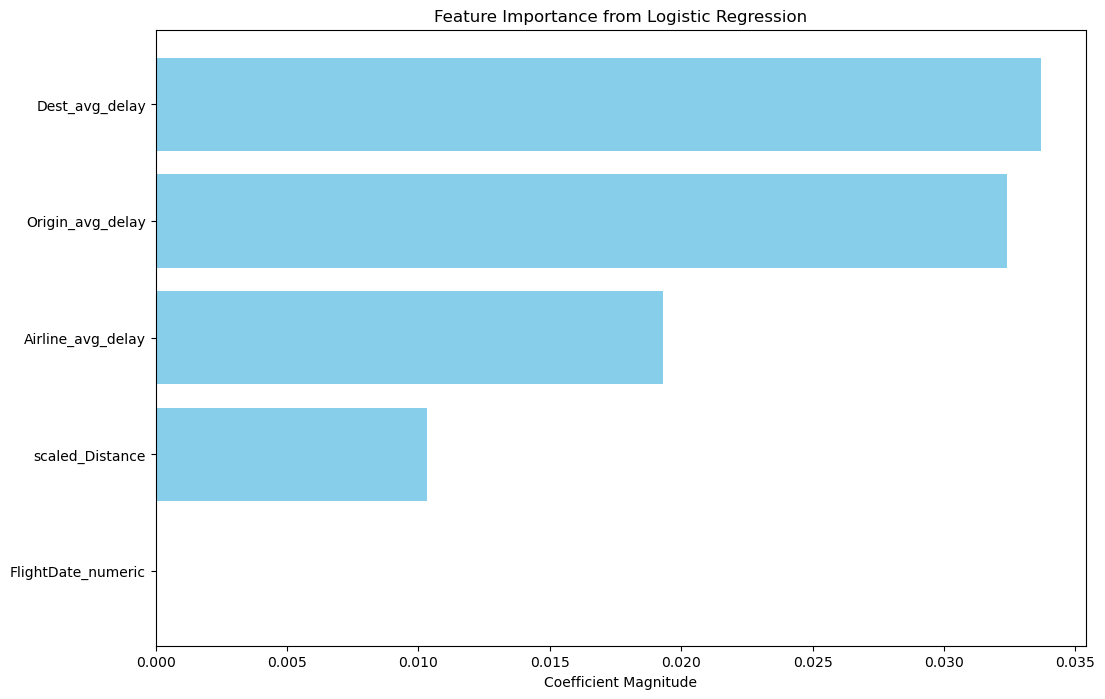

In [ ]:
# Plotting feature importance for Logistic Regression
features, importances = zip(*sorted_importance)
indices = np.arange(len(features))

plt.figure(figsize=(12, 8))
plt.barh(indices, np.abs(importances), align='center', color='skyblue')
plt.yticks(indices, features)
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importance from Logistic Regression')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()

In [21]:
# Random Forest Classifier
# rf = RandomForestClassifier(featuresCol="features", labelCol="status_index", numTrees=50, maxDepth=5, weightCol="classWeight")

# Random Forest Classifier with weight column
rf = RandomForestClassifier(featuresCol="features", labelCol="status_index", weightCol="classWeight", numTrees=50, maxDepth=3)


# Create ParamGrid for Cross Validation
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50]) \
    .addGrid(rf.maxDepth, [3, 5]) \
    .build()

# Cross Validator for Random Forest
crossval_rf = CrossValidator(estimator=rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=MulticlassClassificationEvaluator(labelCol="status_index", predictionCol="prediction", metricName="accuracy"),
                             numFolds=3)

In [ ]:

# Fit the Random Forest model with Cross-Validation
cv_rf_model = crossval_rf.fit(train_data)

# Evaluate Random Forest Model
rf_predictions = cv_rf_model.transform(test_data)
rf_accuracy = MulticlassClassificationEvaluator(labelCol="status_index", predictionCol="prediction", metricName="accuracy").evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")

# Extract the best model from CrossValidator
best_rf_model = cv_rf_model.bestModel

Random Forest Accuracy: 0.4890566950113265


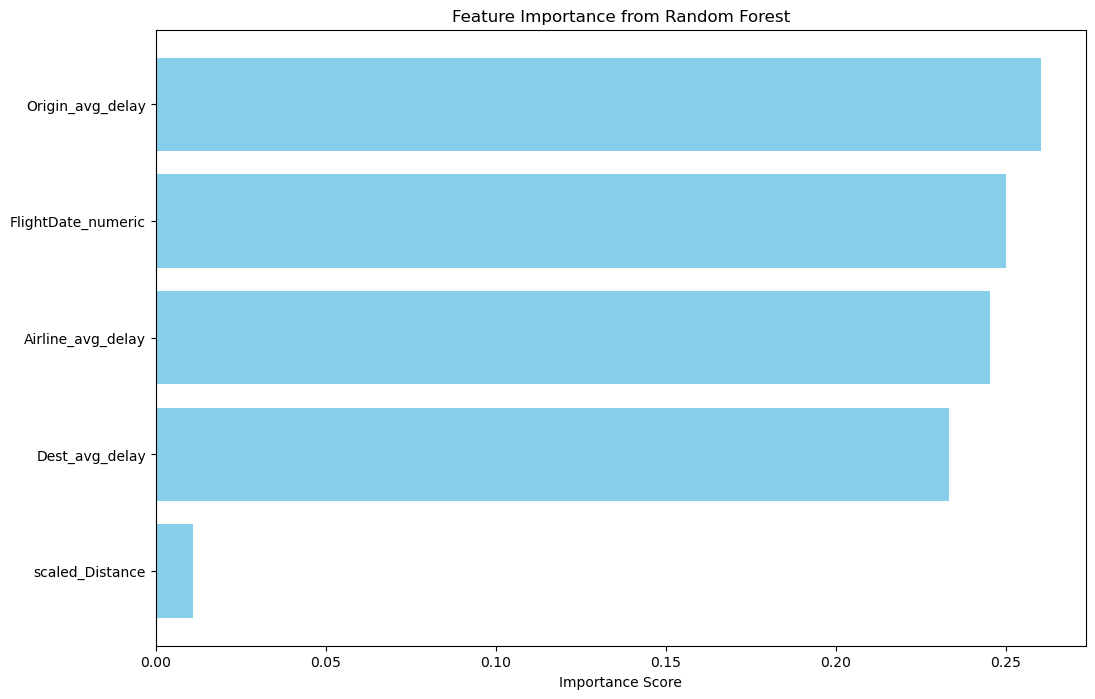

In [ ]:
# Random Forest Feature Importance
import matplotlib.pyplot as plt
import numpy as np

rf_feature_importance = best_rf_model.featureImportances.toArray()
feature_importance = list(zip(feature_cols, rf_feature_importance))
sorted_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

# Plotting feature importance
features, importances = zip(*sorted_importance)
indices = np.arange(len(features))

plt.figure(figsize=(12, 8))
plt.barh(indices, importances, align='center', color='skyblue')
plt.yticks(indices, features)
plt.xlabel('Importance Score')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()

In [28]:
# Importing GraphFrames library
from graphframes import GraphFrame

# Prepare vertices (airports) and edges (flights) DataFrames
vertices = df.select(col("Origin").alias("id")).distinct()  # Airport nodes
edges = df.select(col("Origin").alias("src"), col("Dest").alias("dst"))  # Flight connections

# Create GraphFrame
graph = GraphFrame(vertices, edges)

# PageRank Analysis
# Run PageRank to identify important airports
page_rank_results = graph.pageRank(resetProbability=0.15, maxIter=10)

# Display top airports by PageRank value
page_rank_results.vertices.orderBy(F.desc("pagerank")).show(10)

# Finding Optimal Routes Between High-Ranking Airports
# Extract top-ranking airports to focus on key hubs
top_airports = page_rank_results.vertices.orderBy(F.desc("pagerank")).limit(10)

# Use shortestPaths to find shortest paths between high-ranking airports
# Cache the graph to avoid re-computation issues and improve performance
graph.persist(StorageLevel.MEMORY_AND_DISK)
shortest_paths = graph.shortestPaths(landmarks=[row["id"] for row in top_airports.collect()])

# Filter and display shortest paths between high-ranking airports
shortest_paths_filtered = shortest_paths.filter(col("id").isin([row["id"] for row in top_airports.collect()]))
shortest_paths_filtered.show(truncate=False)

# Notes on Analysis:
# - PageRank helps identify major hubs in the flight network, allowing better resource allocation.
# - Shortest paths analysis reveals optimal routes between high-ranking airports, providing reliable travel options during disruptions.


24/11/28 23:41:40 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


+---+------------------+
| id|          pagerank|
+---+------------------+
|ATL| 21.60618006631491|
|ORD|18.858234176219604|
|DFW| 16.30353177518328|
|DEN|15.814028282148824|
|LAX|11.186796328597213|
|IAH| 9.293570618790369|
|PHX| 9.112856985580517|
|SFO| 8.714274637110567|
|CLT| 8.479963588356165|
|SEA|  8.27337637997787|
+---+------------------+
only showing top 10 rows



24/11/28 23:44:03 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.
24/11/28 23:44:03 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


+---+----------------------------------------------------------------------------------------------------+
|id |distances                                                                                           |
+---+----------------------------------------------------------------------------------------------------+
|CLT|{ORD -> 1, LAX -> 1, ATL -> 1, CLT -> 0, SEA -> 1, PHX -> 1, IAH -> 1, SFO -> 1, DFW -> 1, DEN -> 1}|
|PHX|{ORD -> 1, LAX -> 1, ATL -> 1, CLT -> 1, SEA -> 1, PHX -> 0, IAH -> 1, SFO -> 1, DFW -> 1, DEN -> 1}|
|DFW|{ORD -> 1, LAX -> 1, ATL -> 1, CLT -> 1, SEA -> 1, PHX -> 1, IAH -> 1, SFO -> 1, DFW -> 0, DEN -> 1}|
|SFO|{ORD -> 1, LAX -> 1, ATL -> 1, CLT -> 1, SEA -> 1, PHX -> 1, IAH -> 1, SFO -> 0, DFW -> 1, DEN -> 1}|
|ATL|{ORD -> 1, LAX -> 1, ATL -> 0, CLT -> 1, SEA -> 1, PHX -> 1, IAH -> 1, SFO -> 1, DFW -> 1, DEN -> 1}|
|IAH|{ORD -> 1, LAX -> 1, ATL -> 1, CLT -> 1, SEA -> 1, PHX -> 1, IAH -> 0, SFO -> 1, DFW -> 1, DEN -> 1}|
|ORD|{ORD -> 0, LAX -> 1, ATL -> 1, C

Flight delay prediction is a challenging task in itself, especially in the absence of some key features (e.g., weather data, air traffic control, crew availability, etc.). 82.8% shows that the model has some predictive capability based on the available data.

Why want to perform Shortest paths analysis?

1. Reliability During Disruptions: In events such as weather disturbances or pandemics (e.g., COVID-19), having insight into the shortest and most efficient routes between major airports can help airlines make decisions to reroute flights quickly and efficiently.

2. Resource Allocation: It allows airline companies to allocate resources like fuel, staff, and aircraft to the routes that are most crucial for maintaining overall network efficiency, especially during critical periods.

3. Flexibility and Efficiency: Knowing the shortest paths between highly connected airports allows airlines to maintain efficient operations, minimize costs, and provide flexible travel options for passengers.

In [ ]:
# Business Insights from Graph Analysis
print("\nSummary of Graph Analysis:\n")
print("1. PageRank Analysis revealed the key airports acting as network hubs, enabling better resource allocation.")
print("2. Shortest Path Analysis identified optimal connection routes for passengers, which can be leveraged for better scheduling.")